In [1]:
# THIS SOFTWARE IS PROVIDED BY THE AUTHOR ``AS IS'' AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE

# Load the libraries we loaded into to Docker container
import tensorflow as tf
from tensorflow import keras
import numpy as np
from numpy.random import random
import pandas as pd
from matplotlib import pyplot
from sklearn import preprocessing  #Used for scaling/normalising the data
from sklearn.model_selection import train_test_split
import requests
import io
import seaborn as sns
import flask
from flask import Flask, render_template, request

In [2]:
# Retrieve the dataset for training and testing.
url="https://gist.githubusercontent.com/meperezcuello/82a9f1c1c473d6585e750ad2e3c05a41/raw/d42d226d0dd64e7f5395a0eec1b9190a10edbc03/Medical_Cost.csv"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))  # Read in the remote CSV file

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


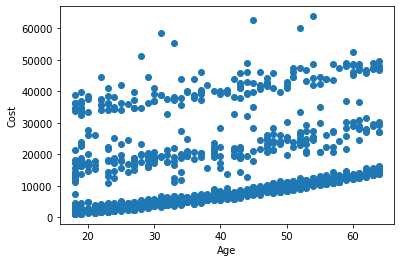

In [3]:
# Show the first few lines of the data and a chart.
# You can really see three different linear datasets.
print(c.head())
pyplot.scatter(c["age"], c["charges"])         # Create a scatter plot to visualise the data
pyplot.xlabel("Age")
pyplot.ylabel("Cost")
pyplot.show()                                  # Display the plot

In [4]:
# The dataset contains some textual values so we need to map these to
# numerical values so they can be analysed.
# Here we map, Sex (M/F), Smoker (Y/N), and Region to numerics. 

def codeSex(textvalue):
    if textvalue == "male":
        return 0
    elif textvalue == "female":
        return 1
    else:
        return -1  
    
def codeSmoker(textvalue):
    if textvalue == "no":
        return 0
    elif textvalue == "yes":
        return 1
    else:
        return -1  
    
def codeRegion(textvalue):
    if textvalue == "southwest":
        return 1
    elif textvalue == "southeast":
        return 2
    elif textvalue == "northwest":
        return 3
    elif textvalue == "northeast":
        return 4
    else:
        return 0   
    
c["sex"] = c["sex"].apply(codeSex)
c["smoker"] = c["smoker"].apply(codeSmoker)
c["region"] = c["region"].apply(codeRegion)

print(c.head())

   age  sex     bmi  children  smoker  region      charges
0   19    1  27.900         0       1       1  16884.92400
1   18    0  33.770         1       0       2   1725.55230
2   28    0  33.000         3       0       2   4449.46200
3   33    0  22.705         0       0       3  21984.47061
4   32    0  28.880         0       0       3   3866.85520


charges     1.000000
smoker      0.787251
age         0.299008
bmi         0.198341
children    0.067998
region      0.006208
sex        -0.057292
Name: charges, dtype: float64


<AxesSubplot:>

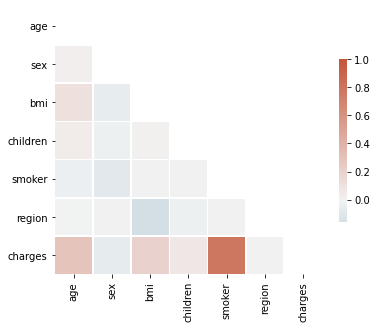

In [5]:
# Create the correlation to determine the influencing factors on 'Charges'  
df = pd.DataFrame(c)
correlation = df.corr()
factors = correlation["charges"]
print(factors.sort_values(ascending=False))

f, ax = pyplot.subplots(figsize=(6, 6))
mask = np.triu(np.ones_like(correlation, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

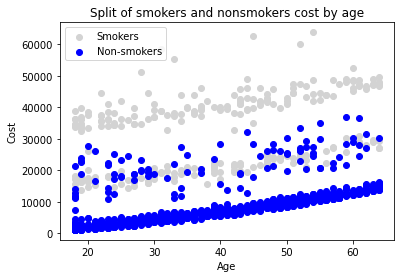

In [6]:
# It looks like being a smoker is the biggest factor, closely followed by Age.
# Non-Smokers are shown in Blue, and Smokers in 'smokey-grey'
# Since Smoker is a binary value, let's focus on the non-smokers and look for a linear prediction pattern.
nonsmokers = c[c['smoker']==0]
nonsmokers = nonsmokers.drop(['smoker'],axis=1)
smokers = c[c['smoker']==1] 
pyplot.scatter(x=smokers["age"],y=smokers["charges"],color='LightGrey',label="Smokers")
pyplot.scatter(x=nonsmokers["age"],y=nonsmokers["charges"],color='Blue',label="Non-smokers")
pyplot.title("Split of smokers and nonsmokers cost by age")
pyplot.xlabel("Age")
pyplot.ylabel("Cost")
pyplot.legend()

In [7]:
# Create the correlation to determine the influencing factors on 'Charges', for non-smokers only
# The chart below shows that 'Age' is the largest influencing factor.
df = pd.DataFrame(nonsmokers)
correlation = df.corr()
factors = correlation["charges"]
print(factors.sort_values(ascending=False))

charges     1.000000
age         0.627947
children    0.138929
bmi         0.084037
region      0.073316
sex         0.056320
Name: charges, dtype: float64


Text(0, 0.5, 'Cost')

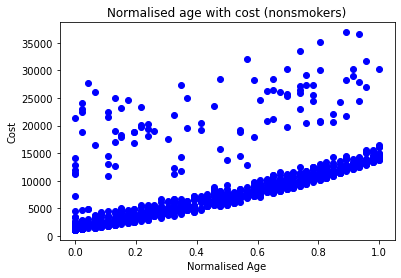

In [8]:
# Before fitting the model, best practice is to scale the input values to stop model fitting exploding.
# Here we normalise only the input values (Age) to a unit range (between 0-1)
# We create a 'scaler' to do this.
nonsmokerssxy = np.column_stack((nonsmokers["age"], nonsmokers["charges"]))
mm_scaler = preprocessing.MinMaxScaler()
XY_train_minmax = mm_scaler.fit_transform(nonsmokerssxy)
xn,yn = XY_train_minmax[:,0], XY_train_minmax[:,1]
pyplot.scatter(x=xn,y=nonsmokers["charges"],color='Blue')
pyplot.title("Normalised age with cost (nonsmokers)")
pyplot.xlabel("Normalised Age")
pyplot.ylabel("Cost")

In [9]:
#Create a test training set but using 95% of the data, and leave 5% for testing
x_train,x_test,y_train,y_test=train_test_split(xn,nonsmokers['charges'],test_size=0.05)
print("Size of training set:", x_train.size)  # We will train the model on this data
print("Size of test set:", x_test.size)       # We will test the model against this data we have held back

Size of training set: 1010
Size of test set: 54


In [10]:
print("Training model")
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(x=x_train, y=y_train, epochs=1000,shuffle=False,verbose=0)
print("Training done")

Training model
Training done


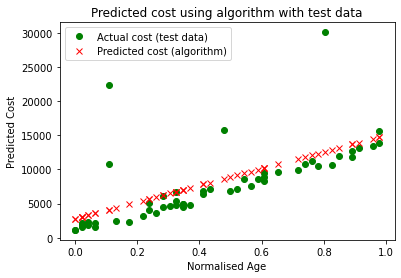

In [11]:
# Test using the test data set (which hasn't been used by the training set)
# Show the testing data (green dots) along side the corresponding predicted costs
y_predict = []
for item in x_test:
    pp = model.predict([item])
    y_predict.append(pp[0][0])
pyplot.plot(x_test,y_test,"go",label="Actual cost (test data)") #Orginal
pyplot.plot(x_test,y_predict,"rx",label="Predicted cost (algorithm)") #Prediction
pyplot.title("Predicted cost using algorithm with test data")
pyplot.xlabel("Normalised Age")
pyplot.ylabel("Predicted Cost")
pyplot.legend()
pyplot.show()

In [ ]:
# Make the prediction algorithm through an API
# so it can be consumed through an App.
app=Flask(__name__)
@app.route("/predict",methods = ["GET"])
def result():
 if request.method == "GET": 
     age = request.args.get("age")                               #Retrieve the Age from the URL
     scaler_input_array = np.array([[age,0]])                    #Create an Array for the scaler
     scaled_age = mm_scaler.transform(scaler_input_array)[0][0]  #Use the scaler we created above
     cost_prediction = model.predict([scaled_age])[0][0]                    #Use the prediction algorithm from above 
     return {"cost" : str(cost_prediction) } 
app.run(host= '0.0.0.0')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
172.17.0.1 - - [11/Jan/2021 12:15:01] "GET / HTTP/1.1" 404 -
172.17.0.1 - - [11/Jan/2021 12:15:01] "GET /favicon.ico HTTP/1.1" 404 -
172.17.0.1 - - [11/Jan/2021 12:15:04] "GET /predict?age=45 HTTP/1.1" 200 -
172.17.0.1 - - [11/Jan/2021 12:15:13] "GET /predict?age=45 HTTP/1.1" 200 -
172.17.0.1 - - [11/Jan/2021 12:15:17] "GET /predict?age=45 HTTP/1.1" 200 -
172.17.0.1 - - [11/Jan/2021 12:15:30] "GET /predict?age=45 HTTP/1.1" 200 -
